#Model 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Wet = pd.read_csv('DataFile_ML_All.csv')
Dry = pd.read_csv('DataFile_ML_Wet.csv')
df = pd.read_csv('DataFile_ML_Dry.csv')

Wet = Wet.drop(columns=['Date', 'id', 'station_code'])
Dry= Dry.drop(columns=['Date', 'id', 'station_code'])
#df = All.drop(columns=['Date', 'id', 'station_code'])

df = df.drop(columns=['Date', 'id', 'station_code'])

# Select the features and target variable
selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite','ATemp_max', 'ATemp_max_1dlag',
    'ATemp_max_2dlag', 'ATemp_max_3dlag', 'ATemp_max_4dlag', 'ATemp_max_5dlag', 'ATemp_max_6dlag', 'ATemp_max_7dlag']

X = df[selected_features]  # Independent variables
y = df['Chlorophyll-a (ug/l)']           # Target variable

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Random Forest Regression Model

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your training data, assuming it's in a DataFrame called 'CDEP'
CDEP = pd.read_csv('DataFile_ML_All.csv')

# Step 1: Data Preprocessing (Assuming your data is in a DataFrame called 'data_CDEP')
selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite', 'ATemp_max' ,'ATemp_max_1dlag',
    'ATemp_max_2dlag', 'ATemp_max_3dlag', 'ATemp_max_4dlag', 'ATemp_max_5dlag', 'ATemp_max_6dlag', 'ATemp_max_7dlag']
X = CDEP[selected_features]  # Independent variables
y = CDEP['Chlorophyll-a (ug/l)']  # Log-transform the target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
#Bayesian Optimization

In [64]:
# Bayesian Optimization
from skopt import gp_minimize

def objective_function(params):
    # Here, params is a list of hyperparameters to optimize
    n_estimators, max_depth, min_samples_split, min_samples_leaf = params

    # Train a model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Calculate the MAE as the metric to minimize
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae  # We want to minimize MAE

from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define the search space for hyperparameters
space = [
    Integer(1, 200, name='n_estimators'),
    Integer(1, 30, name='max_depth'),
    Integer(2, 10, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf')
]

# Perform Bayesian optimization to minimize MAE
result = gp_minimize(objective_function, space, n_calls=10, random_state=42)

# The result variable will contain the optimal hyperparameters that minimize MAE
optimal_hyperparameters = result.x
optimal_mae = result.fun

# Print all hyperparameters and their values
for param, value in zip(space, optimal_hyperparameters):
    print(f"Hyperparameter {param.name}: {value}")
print("Optimal MAE:", optimal_mae)

Hyperparameter n_estimators: 94
Hyperparameter max_depth: 26
Hyperparameter min_samples_split: 7
Hyperparameter min_samples_leaf: 5
Optimal MAE: 2.3367156873975334


Hyperparameter n_estimators: 94
Hyperparameter max_depth: 26
Hyperparameter min_samples_split: 7
Hyperparameter min_samples_leaf: 5
Optimal MAE: 2.3367156873975334

In [74]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Bayesian_02 = RandomForestRegressor(
        random_state=42, 
        n_estimators=96, 
        max_depth=26, 
        min_samples_split=7, 
        min_samples_leaf=5
    )
    rf_model_HAB_Bayesian_02.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Bayesian_02) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)

    # Step 4: Evaluate the Model for Mean Wind Pressure Coefficient

    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.7296140925808782
Average Test R2: 0.5972166464409753
Average Train MSE: 7.279729087109781
Average Test MSE: 10.434542261951519
Average Train RMSE: 2.6979413517968713
Average Test RMSE: 3.2301542906809955
Average Train MAE: 1.7826884634153248
Average Test MAE: 2.304703087111711
Average Train PBIAS: -34.78538257236756
Average Test PBIAS: -41.32946452968255


In [75]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Bayesian_02.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Bayesian_02, file)
    
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Bayesian_02, 'rf_model_HAB_Bayesian_02.joblib')

['rf_model_HAB_Bayesian_02.joblib']

In [ ]:
#Grid Search Optimization

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

# Define the hyperparameter space
param_grid = {
    'n_estimators': [1, 100],
    'max_depth': [22, 24, 26],
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [3, 5, 7, 9]
}

# Create the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define MAE as a scorer
mae_scorer = make_scorer(mean_absolute_error)

# Perform grid search with MAE scoring
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring=mae_scorer, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print the best parameters and MAE
best_params = grid_search.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"MAE: {mae}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters:
max_depth: 22
min_samples_leaf: 3
min_samples_split: 6
n_estimators: 1
MAE: 3.045416378056448


In [86]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Grid_02 = RandomForestRegressor(
        random_state=42, 
        max_depth= 22,
        min_samples_leaf= 3,
        min_samples_split= 6,
        n_estimators= 1
    )
    rf_model_HAB_Grid_02.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Grid_02) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)

 

    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.7592450855289983
Average Test R2: 0.6073654941993157
Average Train MSE: 6.481959694084391
Average Test MSE: 10.171625287084545
Average Train RMSE: 2.536782294928494
Average Test RMSE: 3.1838353291874575
Average Train MAE: 1.6445395694129121
Average Test MAE: 2.292290843043412
Average Train PBIAS: -31.58859808073825
Average Test PBIAS: -39.119703767037606


In [87]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Grid_02.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Grid_02, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Grid_02, 'rf_model_HAB_Grid_02.joblib')

['rf_model_HAB_Grid_02.joblib']

In [ ]:
#randomized search optimization

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Define the hyperparameter space
param_dist = {
    'n_estimators': [1, 100],
    'max_depth': [22, 24, 26],
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [3, 5, 7, 9]
}

# Create the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define MAE as a scorer
mae_scorer = make_scorer(mean_absolute_error)

# Perform randomized search with MAE scoring
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring=mae_scorer, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print the best parameters and MAE
best_params = random_search.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"MAE: {mae}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters:
n_estimators: 1
min_samples_split: 6
min_samples_leaf: 3
max_depth: 22
MAE: 3.045416378056448


In [83]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Random_02 = RandomForestRegressor(
        random_state=42, 
        n_estimators=1, 
        max_depth=22, 
        min_samples_split=6, 
        min_samples_leaf=3
    )
    rf_model_HAB_Random_02.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Random_02) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)

    # Step 4: Evaluate the Model for Mean Wind Pressure Coefficient

    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.7763123443430833
Average Test R2: 0.5920001578377242
Average Train MSE: 6.022449723272423
Average Test MSE: 10.56968109107305
Average Train RMSE: 2.441883717921042
Average Test RMSE: 3.241944807677713
Average Train MAE: 1.6153122102280155
Average Test MAE: 2.3444619285534407
Average Train PBIAS: -32.09755843319084
Average Test PBIAS: -42.75252117150535


In [84]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Random_02.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Random_02, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Random_02, 'rf_model_HAB_Random_02.joblib')

['rf_model_HAB_Random_02.joblib']

In [ ]:
#Normal Code:

0.7784706573185987
5.964340430902421
2.442199916244045
1.6109056063831775
-32.30618731782941
0.6131190618670703
10.022572838775286
3.1658447275214376
2.283058047467636
-43.384036498999926


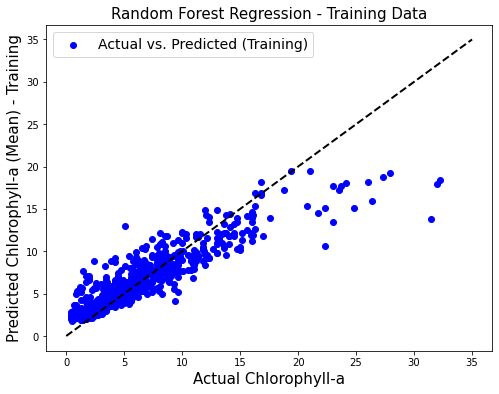

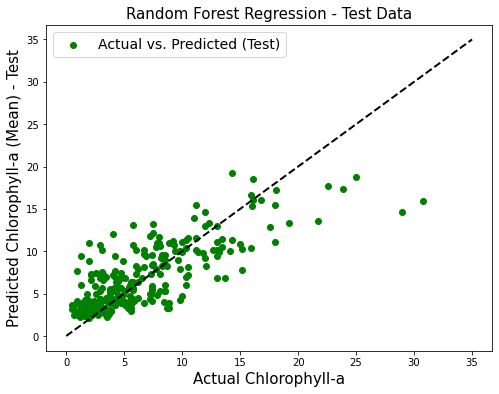

In [79]:
# Number of iterations (J) for the Improved Random Forest
J = 100  # You can adjust the number of iterations as needed

# Lists to store individual decision tree models
decision_trees_mean = []

# Step 2: Training J Decision Trees
for j in range(J):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model = RandomForestRegressor(random_state=42, n_estimators=1, max_depth=22, min_samples_split=6, min_samples_leaf=3)
    rf_model.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model)  # For mean wind pressure coefficient

# Step 3: Predictions and Combining Decision Trees
def combine_decision_trees(predictions):
    return np.mean(predictions, axis=0)

# Predictions
predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
combined_predictions_mean_train = combine_decision_trees(predictions_mean_train)

predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
combined_predictions_mean_test = combine_decision_trees(predictions_mean_test)

# Step 4: Evaluate the Model
# Calculate performance metrics for the current iteration
r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
rmse_mean_train = np.sqrt(mse_mean_train)
rmse_mean_test = np.sqrt(mse_mean_test)
mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

# Calculate PBIAS (Percent Bias)
pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

print(r2_mean_train)
print(mse_mean_train)
print(rmse_mean_train)
print(mae_mean_train)
print(pbias_train)

print(r2_mean_test)
print(mse_mean_test)
print(rmse_mean_test)
print(mae_mean_test)
print(pbias_test)

# Plot the results for training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, combined_predictions_mean_train, c='blue', label='Actual vs. Predicted (Training)')
plt.plot([0, 35], [0, 35], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a', fontsize=15)
plt.ylabel('Predicted Chlorophyll-a (Mean) - Training', fontsize=15)
plt.title ('Random Forest Regression - Training Data', fontsize=15)
plt.legend(fontsize=14)
plt.show()

# Plot the results for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, combined_predictions_mean_test, c='green', label='Actual vs. Predicted (Test)')
plt.plot([0, 35], [0, 35], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a', fontsize=15)
plt.ylabel('Predicted Chlorophyll-a (Mean) - Test', fontsize=15)
plt.title ('Random Forest Regression - Test Data', fontsize=15)
plt.legend(fontsize=14)
plt.show()

### Linear Correction

In [91]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import pickle
import joblib
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the previously saved Random Forest model using pickle
with open('rf_model_HAB_Grid_02.pkl', 'rb') as file:
    rf_model = pickle.load(file)

# Make predictions using the loaded Random Forest model on the training data
original_predictions = rf_model.predict(X_train)

original_test_predictions = rf_model.predict(X_test)

# Step 1: Find Residuals for Training Data
residuals = y_train - original_predictions

# Step 2: Train a Linear Regression Model for Residuals
rf_second = rf_model()
linear_reg_model.fit(X_train, residuals)

# Step 3: Predict Residuals on Training Data
predicted_residuals = linear_reg_model.predict(X_train)

# Step 4: Adjust the Original Prediction
adjusted_predictions = original_predictions + predicted_residuals

# Step 5: Evaluate the Combined Model on Test Data
adjusted_test_predictions = original_test_predictions + linear_reg_model.predict(X_test)

# Step 6: Calculate Evaluation Metrics
# Calculate R2, MSE, RMSE, MAE, and PBIAS for both training and test data
r2_train = r2_score(y_train, adjusted_predictions)
mse_train = mean_squared_error(y_train, adjusted_predictions)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, adjusted_predictions)

r2_test = r2_score(y_test, adjusted_test_predictions)
mse_test = mean_squared_error(y_test, adjusted_test_predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, adjusted_test_predictions)

# PBIAS calculation
pbias_train = ((y_train - adjusted_predictions) / y_train).mean() * 100
pbias_test = ((y_test - adjusted_test_predictions) / y_test).mean() * 100

# Step 7: Compare the Results
# Create plots to compare the performance of the original model and the adjusted model
# (You can use the same plotting code you used before)

# Print the evaluation metrics
print("Combined Model - Train Data")
print(f"R2: {r2_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"PBIAS: {pbias_train}")

print("Combined Model - Test Data")
print(f"R2: {r2_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"PBIAS: {pbias_test}")

Combined Model - Train Data
R2: 0.39313751382110473
MSE: 16.33884892404652
RMSE: 4.042134204111304
MAE: 2.5496950952097848
PBIAS: -24.708773889279662
Combined Model - Test Data
R2: 0.21996386993073747
MSE: 20.20768706833878
RMSE: 4.4952961046341295
MAE: 3.1400844461512047
PBIAS: -33.72621795251651


In [90]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Step 1: Find Residuals for Training Data
residuals = y_train - original_predictions

# Step 2: Train a Linear Regression Model for Residuals
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, residuals)

# Step 3: Predict Residuals on Training Data
predicted_residuals = linear_reg_model.predict(X_train)

# Step 4: Adjust the Original Prediction
adjusted_predictions = original_predictions + predicted_residuals

# Step 5: Evaluate the Combined Model on Test Data
test_residuals = y_test - original_test_predictions
adjusted_test_predictions = original_test_predictions + linear_reg_model.predict(X_test)

# Step 6: Calculate Evaluation Metrics
# Calculate R2, MSE, RMSE, MAE, and PBIAS for both training and test data
r2_train = r2_score(y_train, adjusted_predictions)
mse_train = mean_squared_error(y_train, adjusted_predictions)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, adjusted_predictions)

r2_test = r2_score(y_test, adjusted_test_predictions)
mse_test = mean_squared_error(y_test, adjusted_test_predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, adjusted_test_predictions)

# PBIAS calculation
pbias_train = ((y_train - adjusted_predictions) / y_train).mean() * 100
pbias_test = ((y_test - adjusted_test_predictions) / y_test).mean() * 100

# Step 7: Compare the Results
# Create plots to compare the performance of the original model and the adjusted model
# (You can use the same plotting code you used before)

# Print the evaluation metrics
print("Combined Model - Train Data")
print(f"R2: {r2_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"PBIAS: {pbias_train}")

print("Combined Model - Test Data")
print(f"R2: {r2_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"PBIAS: {pbias_test}")

NameError: name 'original_test_predictions' is not defined

Combined Model - Train Data
R2: -2.313032878957514
MSE: 89.19836853077217
RMSE: 9.44448879139428
MAE: 7.275747006713398
PBIAS: -176.22193816222443


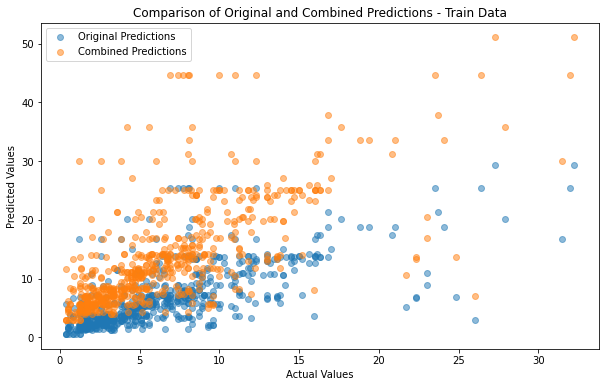

In [88]:
import pickle
import joblib
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the previously saved Random Forest model using pickle
with open('rf_model_HAB_Grid_02.pkl', 'rb') as file:
    rf_model = pickle.load(file)

# Make predictions using the loaded Random Forest model on the training data
original_predictions = rf_model.predict(X_train)

# Apply linear regression to make corrections
linear_reg = LinearRegression()
linear_reg.fit(original_predictions.reshape(-1, 1), y_train)

# Make linear corrections
corrected_predictions = linear_reg.predict(original_predictions.reshape(-1, 1))

# Combine the corrected predictions with the original predictions
combined_predictions = original_predictions + corrected_predictions

# Save the new combined model
with open('combined_rf_linear_model.pkl', 'wb') as file:
    pickle.dump(combined_predictions, file)

# Evaluate the performance of the combined model
r2_combined = r2_score(y_train, combined_predictions)
mse_combined = mean_squared_error(y_train, combined_predictions)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_train, combined_predictions)

# Calculate PBIAS (Percent Bias)
pbias_combined = ((y_train - combined_predictions) / y_train).mean() * 100

# Print the evaluation metrics
print("Combined Model - Train Data")
print(f"R2: {r2_combined}")
print(f"MSE: {mse_combined}")
print(f"RMSE: {rmse_combined}")
print(f"MAE: {mae_combined}")
print(f"PBIAS: {pbias_combined}")

# Create a plot to compare the predictions before and after linear correction
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_train, original_predictions, label='Original Predictions', alpha=0.5)
plt.scatter(y_train, combined_predictions, label='Combined Predictions', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Comparison of Original and Combined Predictions - Train Data')
plt.show()

In [63]:
### Linear Correction

from sklearn.linear_model import LinearRegression  # Import Linear Regression

# Fit a linear regression model to correct predictions on the training data
linear_correction_model = LinearRegression()
linear_correction_model.fit(np.array(y_train_pred).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

# Apply the linear regression model to correct predictions on the test data
y_train_pred_corr = linear_correction_model.predict(np.array(y_train_pred).reshape(-1, 1))
y_test_pred_corr = linear_correction_model.predict(np.array(y_test_pred).reshape(-1, 1))

train_mse_corr = mean_squared_error(y_train, y_train_pred_corr)
test_mse_corr = mean_squared_error(y_test, y_test_pred_corr)
train_rmse_corr = np.sqrt(train_mse)
test_rmse_corr = np.sqrt(test_mse)
train_r2_corr = r2_score(y_train, y_train_pred_corr)
test_r2_corr = r2_score(y_test, y_test_pred_corr)
train_mae_corr = mean_absolute_error(y_train, y_train_pred_corr)
test_mae_corr = mean_absolute_error(y_test, y_test_pred_corr)



# Print metrics
print(f'Train MSE: {train_mse_corr:.4f}')
print(f'Test MSE: {test_mse_corr:.4f}')
print(f'Train RMSE: {train_rmse_corr:.4f}')
print(f'Test RMSE: {test_rmse_corr:.4f}')
print(f'Train R2: {train_r2_corr:.4f}')
print(f'Test R2: {test_r2_corr:.4f}')
print(f'Train MAE: {train_mae_corr:.4f}')
print(f'Test MAE: {test_mae_corr:.4f}')

Train MSE: 1.0532
Test MSE: 9.4149
Train RMSE: 1.3413
Test RMSE: 3.0453
Train R2: 0.9579
Test R2: 0.4172
Train MAE: 0.7464
Test MAE: 2.2371
